# Install ptitprince and load libraries

In [1]:
!pip install ptitprince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ptitprince: filename=ptitprince-0.3.1-py3-none-any.whl size=16216 sha256=e3dfb22d38e63fe9a2ec1811aa619073a5ef0b26ce06ff590965839f073b2eb8
  Stored in directory: /root/.cache/pip/wheels/5d/79/49/b89a41fd3d8780ce2c21c7f2debe45f3c6b08d8aef400e3df1
Successfully built ptitprince


In [2]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.1 MB/s eta 0:00:00


#Datasets Needed




*combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv and combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries.csv*

# Maps

###urban city

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


Map saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_EVI_map_top1000.png


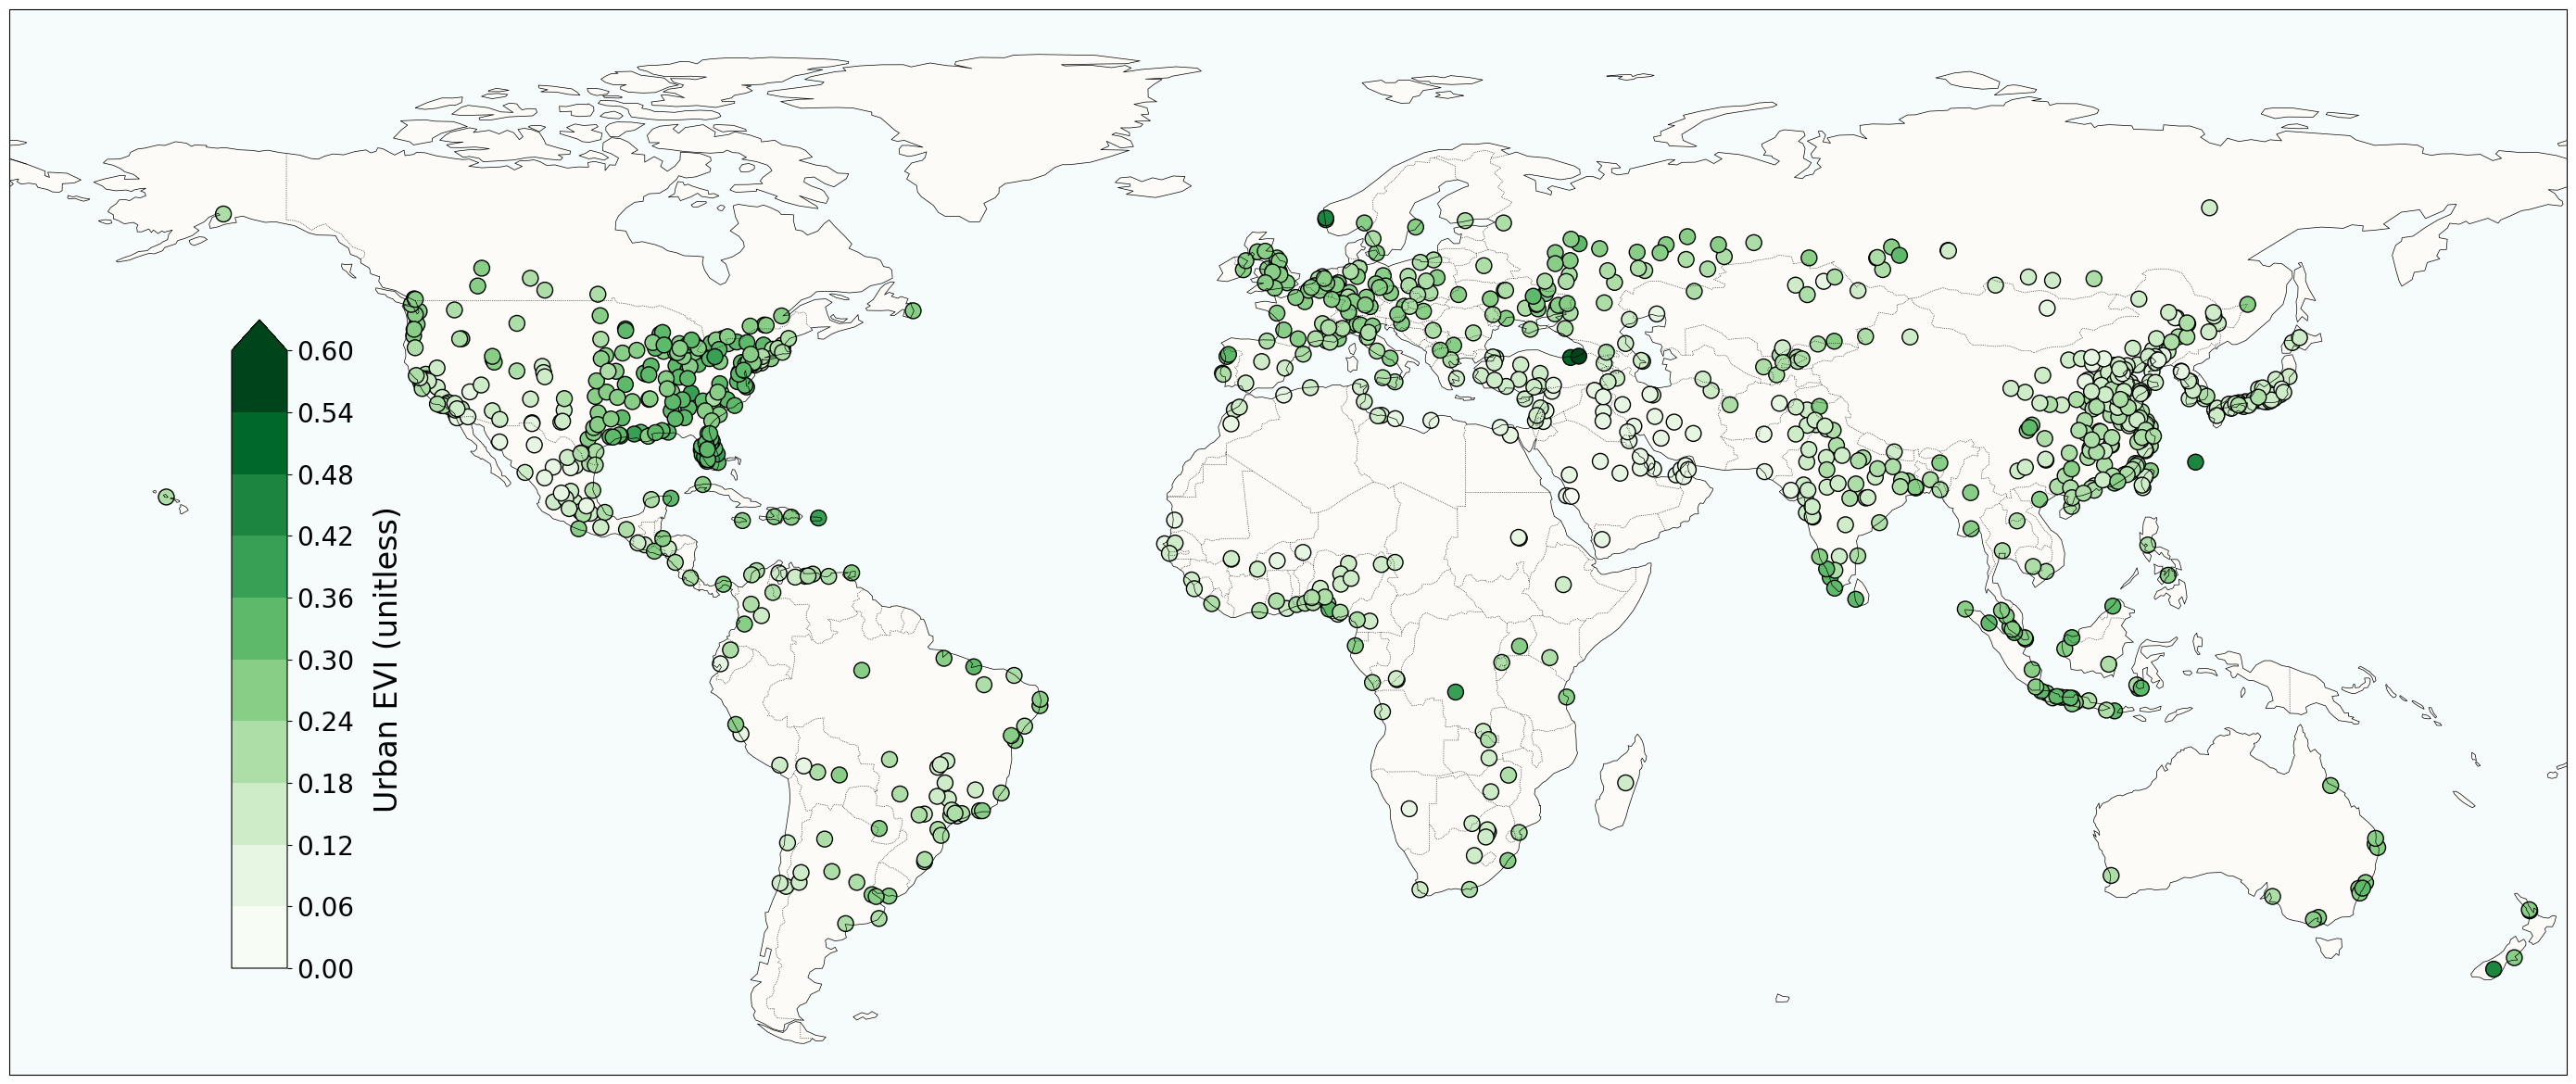

Histogram saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_EVI_hist_top1000.png


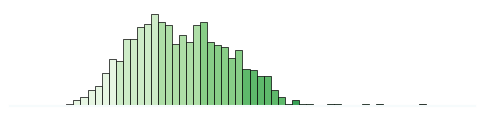

In [3]:
#!/usr/bin/env python3
"""
Visualize Urban EVI for Top 1000 Cities
───────────────────────────────────────
Creates a global scatter map and minimalist histogram of mean EVI values for
the top 1000 cities by urban area.
"""

# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
CSV_PATH = Path('/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv')
OUT_DIR = Path('/content/drive/MyDrive/UrbanVegetation/Figures/')
OUT_MAP = OUT_DIR / 'FigSI1_uvp_EVI_map_top1000.png'
OUT_HIST = OUT_DIR / 'FigSI1_uvp_EVI_hist_top1000.png'

NUM_COLOR_BINS = 10
NUM_HIST_BINS = 60
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 3. HELPER FUNCTION: ROUND TO "NICE" CEIL VALUE
# ------------------------------------------------------------------
def nice_ceil(x, base=0.05):
    return np.ceil(x / base) * base

# ------------------------------------------------------------------
# 4. HELPER FUNCTION: MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])

    if series.empty:
        print("No data available in the specified range for the histogram – skipped.")
        return

    fig, ax = plt.subplots(figsize=(6, 1.25))
    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=0.5
    )

    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)

    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    plt.savefig(path, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()

# ------------------------------------------------------------------
# 5. MAIN FUNCTION
# ------------------------------------------------------------------
def analyze_and_plot_evi(csv_file):
    if not csv_file.is_file():
        raise FileNotFoundError(f"ERROR: Input CSV not found -> {csv_file}")

    df = pd.read_csv(csv_file, low_memory=False)
    df = df.nlargest(1000, 'Urban_Area')

    required_columns = ['meanEVI_2020_urban', 'Urban_Area', 'lat', 'lon']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"ERROR: Missing required column '{col}' in CSV.")
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=required_columns, inplace=True)

    # --- Dynamic Range ---
    vmin = 0.0
    raw_vmax = df['meanEVI_2020_urban'].max()
    vmax = nice_ceil(raw_vmax, base=0.05)  # Round up to nearest 0.05

    bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
    norm = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)

    # --- Map Plot ---
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    scatter = ax.scatter(
        df['lon'],
        df['lat'],
        c=df['meanEVI_2020_urban'],
        cmap=SEQUENTIAL_CMAP,
        norm=norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # --- Color Bar ---
    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
    sm.set_array([])  # Required dummy array
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
    cbar.set_label('Urban EVI (unitless)', fontsize=24, labelpad=15)
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.2f}' for b in bounds])
    cbar.ax.tick_params(labelsize=20)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    plt.savefig(OUT_MAP, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Map saved to -> {OUT_MAP}")
    plt.show()

    # --- Histogram ---
    minimalist_hist(
        series=df['meanEVI_2020_urban'],
        bounds_arr=bounds,
        bins=NUM_HIST_BINS,
        cmap_obj=SEQUENTIAL_CMAP,
        path=OUT_HIST
    )

# ------------------------------------------------------------------
# 6. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    try:
        analyze_and_plot_evi(CSV_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(f"A critical error occurred: {e}", file=sys.stderr)


Map saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_EVI_map_ALL.png


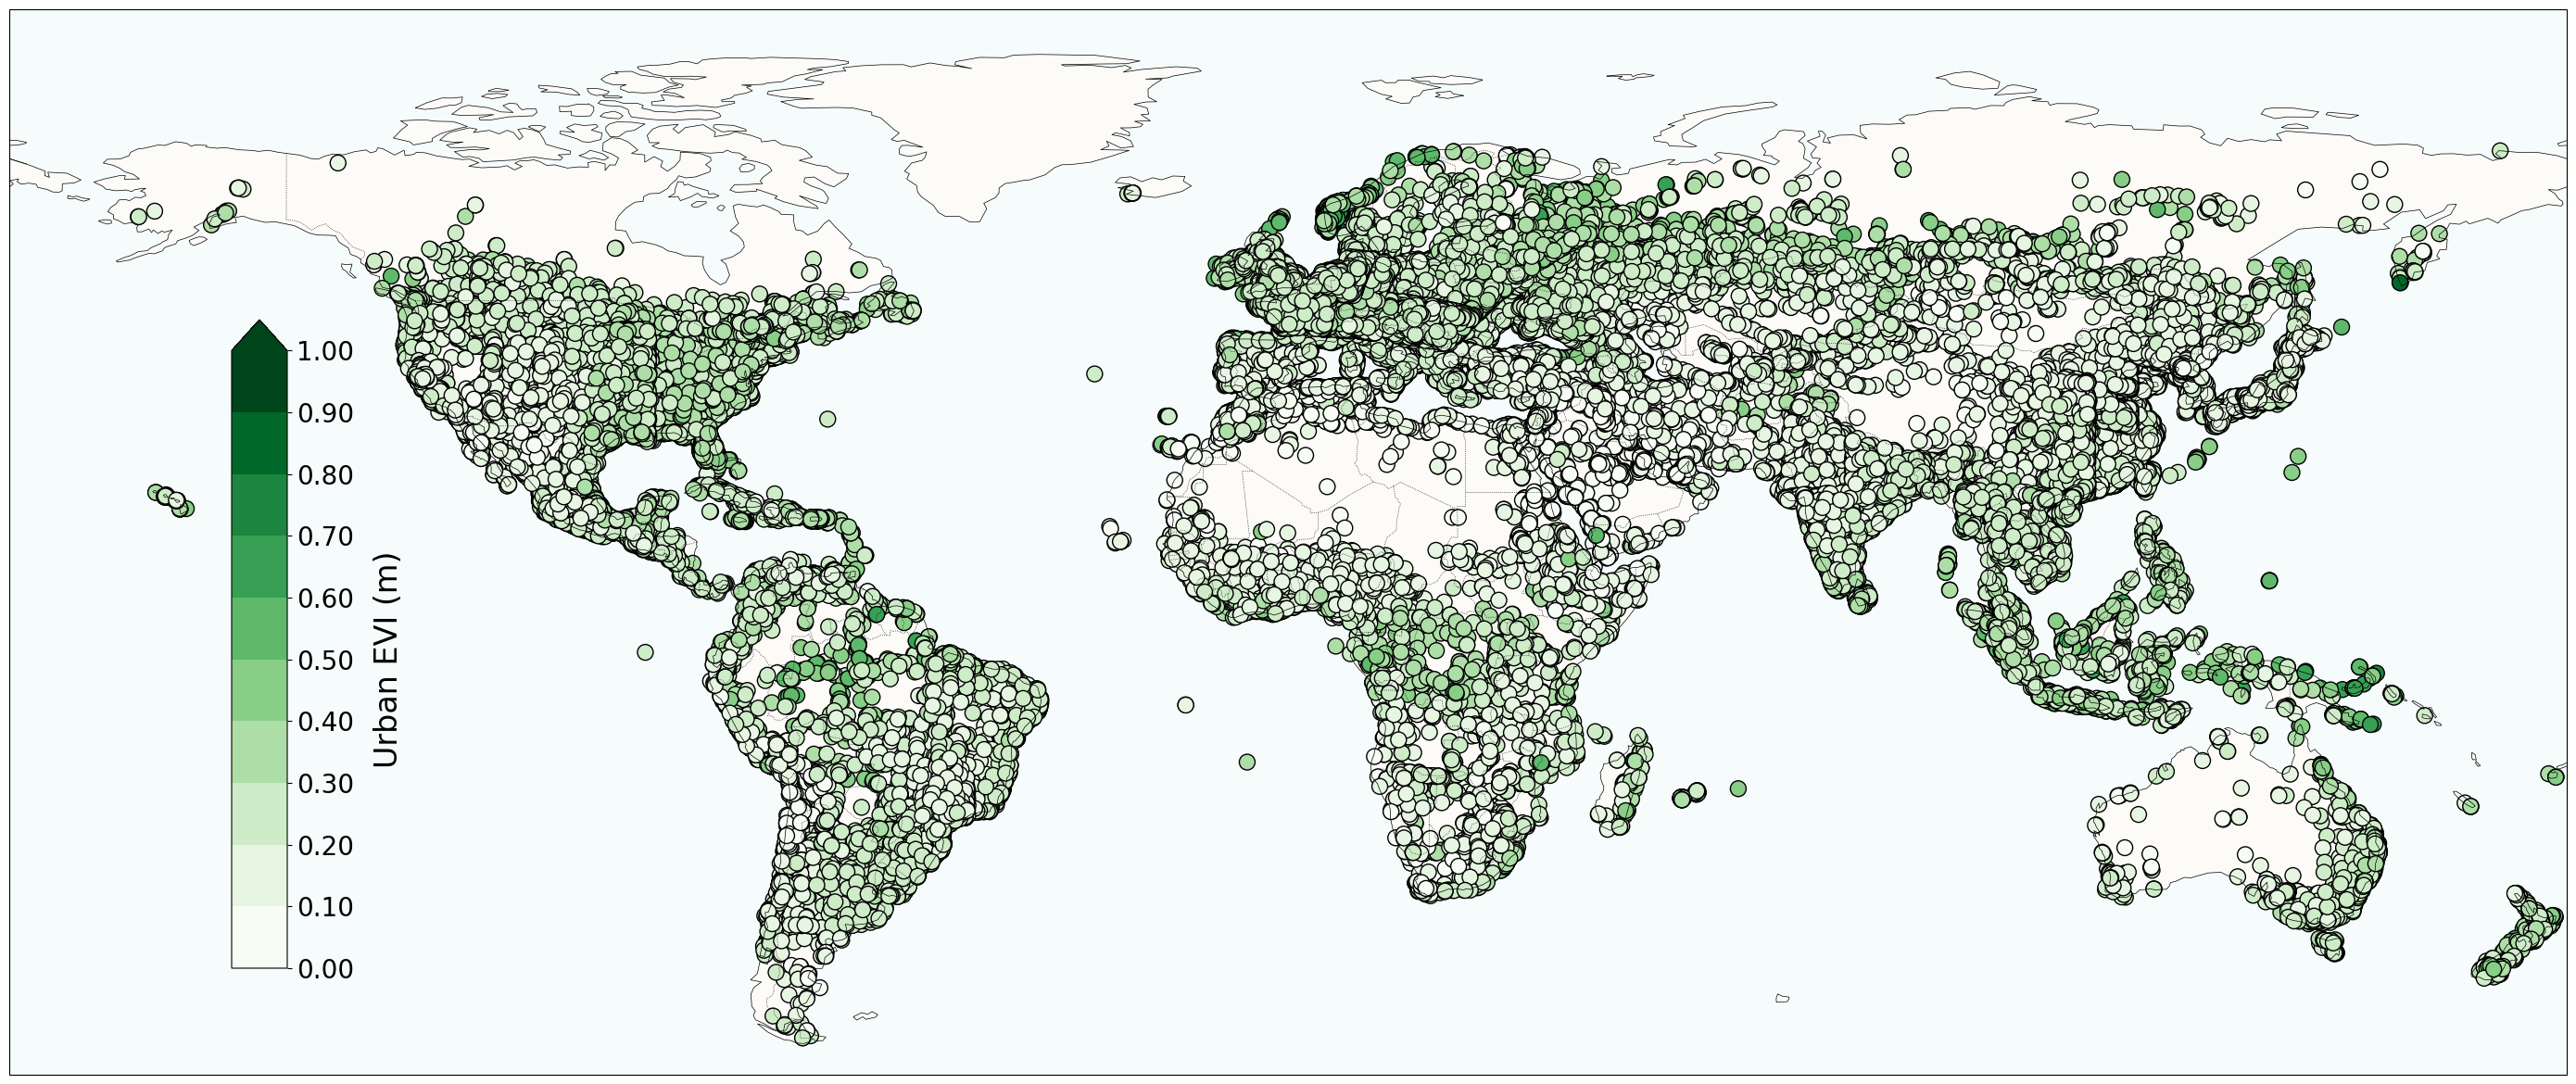

Histogram saved to -> /content/drive/MyDrive/UrbanVegetation/Figures/FigSI1_uvp_EVI_hist_ALL.png


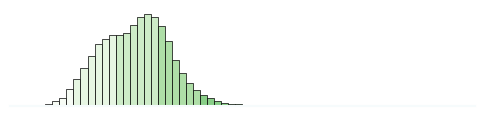

In [4]:
# ------------------------------------------------------------------
# STEP 1: IMPORTS
# ------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# ------------------------------------------------------------------
# STEP 2: CONFIGURATION
# ------------------------------------------------------------------
# Adjust paths for your environment.
# This script assumes the input CSV is in the /content/ directory.
CSV_PATH = Path('/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv')

# Outputs will be saved in the specified directory.
OUT_DIR = Path('/content/drive/MyDrive/UrbanVegetation/Figures/')
OUT_MAP = OUT_DIR / 'FigSI1_uvp_EVI_map_ALL.png'
OUT_HIST = OUT_DIR / 'FigSI1_uvp_EVI_hist_ALL.png'

# --- Parameters ---
# Use 10 distinct color classes for the map and histogram color scale.
NUM_COLOR_BINS = 10
# Use 60 bins for the fine-grained histogram representation.
NUM_HIST_BINS = 60
# A sequential green colormap suitable for vegetation data.
SEQUENTIAL_CMAP = plt.cm.Greens

# ------------------------------------------------------------------
# 3. HELPER FUNCTION: MINIMALIST HISTOGRAM
# ------------------------------------------------------------------
def minimalist_hist(series: pd.Series, bounds_arr, bins, cmap_obj, path):
    """
    Creates a minimalist histogram where each bar is colored according to its
    value, using the same discrete normalization as the map for consistency.
    """
    # Use the same normalization as the map for a direct visual link.
    norm_hist = BoundaryNorm(bounds_arr, ncolors=cmap_obj.N, clip=True)

    # Clip the data series to the exact bounds used in the map.
    series = series.clip(lower=bounds_arr[0], upper=bounds_arr[-1])
    if series.empty:
        print("No data available in the specified range for the histogram – skipped.")
        return

    fig, ax = plt.subplots(figsize=(6, 1.25))

    # Create the histogram.
    counts, edges, patches = ax.hist(
        series,
        bins=np.linspace(bounds_arr[0], bounds_arr[-1], bins + 1),
        edgecolor='black',
        linewidth=0.5
    )

    # Color each histogram bar based on its value's class.
    for p, l, r in zip(patches, edges[:-1], edges[1:]):
        # The color is determined by the midpoint of the bar.
        p.set_facecolor(cmap_obj(norm_hist((l + r) / 2)))

    # Apply minimalist styling: remove ticks, labels, and all spines but the bottom.
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc') # Light color for subtlety
    ax.spines['bottom'].set_linewidth(1.5)

    # Set transparent backgrounds for both the figure and axes.
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    plt.savefig(path, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Histogram saved to -> {path}")
    plt.show()


# ------------------------------------------------------------------
# 4. MAIN ANALYSIS AND VISUALIZATION
# ------------------------------------------------------------------
def analyze_and_plot_tree_height(csv_file):
    """
    Loads urban tree height data, plots it on a global map with a 10-class
    color scale, and generates a corresponding minimalist histogram.
    """
    # --- Data Loading and Preparation ---
    if not csv_file.is_file():
        raise FileNotFoundError(f"ERROR: Input CSV not found -> {csv_file}")

    df = pd.read_csv(csv_file, low_memory=False)
    # df = df.nlargest(1000, 'Urban_Area')

    required_columns = ['meanEVI_2020_urban', 'Urban_Area', 'lat', 'lon']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"ERROR: Missing required column '{col}' in CSV.")
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=required_columns, inplace=True)


    df_top1000 = df

    # --- Color Scale Definition ---
    # Define the data range for tree height (in meters).
    vmin = 0.0
    # Dynamically get vmax by finding the maximum value in the data column.
    # np.ceil() rounds up to the next largest integer for a clean upper bound.
    vmax = np.ceil(df_top1000['meanEVI_2020_urban'].max())


    # Create discrete boundaries for the color bins based on the dynamic range.
    bounds = np.linspace(vmin, vmax, NUM_COLOR_BINS + 1)
    # Create a normalization object to map data values to the discrete colormap.
    norm = BoundaryNorm(bounds, ncolors=SEQUENTIAL_CMAP.N, clip=True)

    # --- City Scatter Map ---
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    # Scatter plot of the top 1000 cities, colored by tree height.
    scatter = ax.scatter(
        df_top1000['lon'],
        df_top1000['lat'],
        c=df_top1000['meanEVI_2020_urban'], # Color based on tree height
        cmap=SEQUENTIAL_CMAP,
        norm=norm,
        s=150,
        alpha=1,
        edgecolors='black',
        linewidths=1,
        transform=ccrs.PlateCarree()
    )

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # --- Color Bar ---
    cbar_ax = fig.add_axes([0.13, 0.27, 0.02, 0.35])
    sm = ScalarMappable(norm=norm, cmap=SEQUENTIAL_CMAP)
    sm.set_array([]) # An array must be set for the mappable to work.
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
    cbar.set_label('Urban EVI (m)', fontsize=24, labelpad=15)

    # Set ticks to the calculated bin edges for clarity.
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f'{b:.2f}' for b in bounds])
    cbar.ax.tick_params(labelsize=20)

    plt.subplots_adjust(left=0.05, right=0.97, top=0.95, bottom=0.05)
    plt.savefig(OUT_MAP, dpi=400, bbox_inches='tight', format='png', transparent=True)
    print(f"Map saved to -> {OUT_MAP}")
    plt.show()

    # --- Minimalist Histogram Generation ---
    # Call the helper function to create the histogram with matching style.
    minimalist_hist(
        series=df_top1000['meanEVI_2020_urban'],
        bounds_arr=bounds,
        bins=NUM_HIST_BINS,
        cmap_obj=SEQUENTIAL_CMAP,
        path=OUT_HIST
    )

# ------------------------------------------------------------------
# 5. EXECUTION
# ------------------------------------------------------------------
if __name__ == "__main__":
    try:
        analyze_and_plot_tree_height(CSV_PATH)
    except (FileNotFoundError, ValueError) as e:
        print(f"A critical error occurred: {e}", file=sys.stderr)

###urban country

An error occurred in choropleth mapping: Error reading shapefile '/content/ne_110m_admin_0_countries.shp': /content/ne_110m_admin_0_countries.shp: No such file or directory


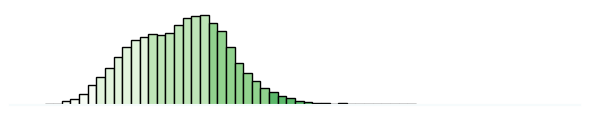

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

def aggregate_mean_tree_height_by_country(data, shapefile_path, save_fig_path):
    """
    Aggregates mean tree height by country and creates a choropleth map
    using a green color ramp with 10 classes.
    """
    # Check required columns
    required_columns = ['meanEVI_2020_urban', 'NAME_EN']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' not found in the data.")

    # Convert tree height column to numeric and drop missing values
    data['meanEVI_2020_urban'] = pd.to_numeric(data['meanEVI_2020_urban'], errors='coerce')
    data_clean = data.dropna(subset=required_columns)

    try:
        country_tree_height = data_clean.groupby('NAME_EN', as_index=False)['meanEVI_2020_urban'].mean()
        country_tree_height.rename(columns={'meanEVI_2020_urban': 'mean_tree_height'}, inplace=True)

        # **Remove countries where mean tree height is exactly 0**
        country_tree_height = country_tree_height[country_tree_height['mean_tree_height'] > 0]

    except Exception as e:
        raise RuntimeError(f"Error during aggregation: {e}")

    try:
        world = gpd.read_file(shapefile_path)
        if 'ADMIN' in world.columns:
            world = world[world['ADMIN'] != 'Antarctica']
        elif 'NAME_EN' in world.columns:
            world = world[world['NAME_EN'] != 'Antarctica']
    except Exception as e:
        raise FileNotFoundError(f"Error reading shapefile '{shapefile_path}': {e}")

    def _standardize_names(s):
        return (s.str.lower()
                .str.replace("&", "and")
                .str.replace("-", " ")
                .str.replace(".", "")
                .str.replace(",", ""))

    try:
        country_tree_height['std_name'] = _standardize_names(country_tree_height['NAME_EN'])
        if 'NAME_EN' in world.columns:
            world['std_name'] = _standardize_names(world['NAME_EN'])
        else:
            world['std_name'] = _standardize_names(world['ADMIN'])
    except Exception as e:
        raise RuntimeError(f"Error standardizing country names: {e}")

    try:
        merged = world.merge(country_tree_height, how='left', on='std_name')
        merged = merged.dropna(subset=['mean_tree_height'])

    except Exception as e:
        raise RuntimeError(f"Error merging geospatial data: {e}")

    if merged.empty:
        raise ValueError("Merged geodataframe is empty after filtering. Check country name matching.")

    try:
        fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})

        ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

        valid_data = merged['mean_tree_height'].dropna()
        if len(valid_data) == 0:
            raise ValueError("No valid mean_tree_height values found for plotting.")

        min_val = max(0, valid_data.min())
        max_val = np.percentile(valid_data, 95)

        # Set the number of classes to 10
        num_bins = 10
        bounds = np.linspace(min_val, max_val, num_bins)

        # Use a green color palette with 10 colors
        cmap = LinearSegmentedColormap.from_list("tree_height_cmap", green_colors, N=256)
        norm = BoundaryNorm(boundaries=bounds, ncolors=256)

        merged.plot(
            column='mean_tree_height',
            ax=ax,
            cmap=cmap,
            norm=norm,
            edgecolor='black',
            linewidth=0.4,
            missing_kwds={'color': 'lightgrey', 'label': 'No data'}
        )

        cbar_ax = fig.add_axes([0.13, 0.3, 0.02, 0.3])
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical', extend='max')
        cbar.set_label('Country-wise\nurban EVI', fontsize=24, labelpad=15)
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
        cbar.ax.tick_params(labelsize=20)

        plt.subplots_adjust(left=0.05, right=0.97, top=0.92, bottom=0.05)
        os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
        plt.savefig(save_fig_path, dpi=400, bbox_inches='tight', format='png')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during plotting: {e}")


def create_tree_height_histogram(data, save_fig_path):
    """
    Creates a standalone histogram of mean tree height values using a green colormap.
    """
    if isinstance(data, pd.DataFrame):
        if 'meanEVI_2020_urban' not in data.columns:
            raise ValueError("Required column 'meanEVI_2020_urban' not found in the data.")
        data_series = data['meanEVI_2020_urban']
    elif isinstance(data, pd.Series):
        data_series = data
    else:
        raise ValueError("Data must be a pandas DataFrame or Series.")

    data_series = pd.to_numeric(data_series, errors='coerce').dropna()

    # **Remove zero values**
    data_series = data_series[data_series > 0]

    if data_series.empty:
        raise ValueError("No valid data available for histogram plotting after removing zero values.")

    min_val = max(0, data_series.min())
    max_val = np.percentile(data_series, 100)

    # Set the number of color bins to 10 for the histogram as well for consistency
    num_color_bins = 10
    bounds = np.linspace(min_val, max_val, num_color_bins)

    cmap = LinearSegmentedColormap.from_list("tree_height_cmap", green_colors, N=256)
    norm = BoundaryNorm(boundaries=bounds, ncolors=256)

    num_hist_bins = 60
    bins = np.linspace(min_val, max_val, num_hist_bins + 1)

    try:
        fig, ax = plt.subplots(figsize=(6, 1.25))
        counts, bin_edges, patches = ax.hist(data_series, bins=bins, edgecolor='black')
        for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
            mid_point = (left_edge + right_edge) / 2.0
            if mid_point > max_val:
                mid_point = max_val
            color_index = norm(mid_point)
            patch.set_facecolor(cmap(color_index))

        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_color('#f6fbfc')
        ax.spines['bottom'].set_linewidth(1.5)

        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)

        plt.tight_layout()
        directory = os.path.dirname(save_fig_path)
        if directory:
            os.makedirs(directory, exist_ok=True)
        plt.savefig(save_fig_path, dpi=400, bbox_inches='tight', format='png')
        plt.show()

    except Exception as e:
        raise RuntimeError(f"Error during histogram plotting: {e}")


if __name__ == "__main__":
    # Define file paths (update these paths as necessary)
    csv_file_path = '/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries.csv'
    shapefile_path = '/content/ne_110m_admin_0_countries.shp'
    choropleth_save_fig_path = '/content/drive/MyDrive/UrbanVegetation/Figures/FigSI3_uvp_EVI_by_country_map.png'
    histogram_save_fig_path = '/content/drive/MyDrive/UrbanVegetation/Figures/FigSI3_uvp_EVI_histogram.png'

    # Define the discrete colormap for the entire visualization with 10 colors
    green_colors = ['#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476',
                    '#41ab5d', '#238b45', '#006d2c', '#00441b', '#002810']


    # Load CSV data with error handling
    try:
        data = pd.read_csv(csv_file_path, low_memory=False)
    except Exception as e:
        raise FileNotFoundError(f"Error reading CSV file '{csv_file_path}': {e}")

    # Generate choropleth map with inset histogram
    try:
        aggregate_mean_tree_height_by_country(data, shapefile_path, choropleth_save_fig_path)
    except Exception as e:
        print(f"An error occurred in choropleth mapping: {e}")

    # Generate a separate histogram plot
    try:
        create_tree_height_histogram(data, histogram_save_fig_path)
    except Exception as e:
        print(f"An error occurred in histogram plotting: {e}")

###urban rural country

In [6]:
#!/usr/bin/env python3


# ─────────────────────────────────────────────────────────────────────────────
# 1. IMPORTS & CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from pathlib import Path

# ─── User Configuration ───────────────────────────────────────────────────────
# Update these to match your environment
CSV_FILE_PATH       = Path("/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries.csv")
SHAPEFILE_PATH      = Path("/content/ne_110m_admin_0_countries.shp")
OUTPUT_DIR          = Path("/content/drive/MyDrive/UrbanVegetation/Figures")

# Output file paths (Updated for EVI and FigS1)
CHOROPLETH_FIG_PATH = OUTPUT_DIR / "FigS1_country_EVI_difference_map.png"
HISTOGRAM_FIG_PATH  = OUTPUT_DIR / "FigS1_country_EVI_difference_histogram.png"

# Parameters
MIN_CITIES          = 1       # Minimum number of cities per country to be included
NUM_COLOR_BINS      = 8       # Use an even number for a symmetric diverging scale
NUM_HIST_BINS       = 60

# Diverging palette (brown -> white -> green), suitable for EVI difference
DIVERGING_COLORS = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
    '#ffffff',
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'
]

# ─────────────────────────────────────────────────────────────────────────────
# 2. HELPER FUNCTION
# ─────────────────────────────────────────────────────────────────────────────
def _standardize_names(s: pd.Series) -> pd.Series:
    """Lower-case & clean names for reliable merging between data and shapefiles."""
    return (s.str.lower()
             .str.replace("&", "and", regex=False)
             .str.replace("-", " ", regex=False)
             .str.replace("[.,]", "", regex=True)
             .str.strip())

# ─────────────────────────────────────────────────────────────────────────────
# 3. DATA PROCESSING
# ─────────────────────────────────────────────────────────────────────────────
def process_data(csv_path: Path, min_cities: int) -> pd.DataFrame:
    """Loads, cleans, and processes EVI data to find the urban-rural difference."""
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV file not found at: {csv_path}")

    df = pd.read_csv(csv_path, low_memory=False)

    # --- Verify required columns for EVI ---
    required_cols = ["meanEVI_2020_urban", "meanEVI_2020_rural", "NAME_EN"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Required columns not found in the CSV: {missing_cols}")

    # --- Calculate difference ---
    for col in ["meanEVI_2020_urban", "meanEVI_2020_rural"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=required_cols, inplace=True)

    df['EVI_diff'] = df['meanEVI_2020_urban'] - df['meanEVI_2020_rural']
    df = df[df['EVI_diff'] != 0] # Drop rows with no difference

    # --- Filter by city count and aggregate ---
    city_counts = df['NAME_EN'].value_counts()
    valid_countries = city_counts[city_counts >= min_cities].index
    print(f"Keeping {len(valid_countries)} countries with at least {min_cities} city/cities.")

    country_diff = (df[df['NAME_EN'].isin(valid_countries)]
                      .groupby("NAME_EN", as_index=False)['EVI_diff']
                      .mean()
                      .rename(columns={"EVI_diff": "mean_EVI_diff"}))

    return country_diff

# ─────────────────────────────────────────────────────────────────────────────
# 4. VISUALISATION
# ─────────────────────────────────────────────────────────────────────────────
def create_difference_choropleth(data: pd.DataFrame, shapefile_path: Path, save_fig_path: Path) -> None:
    """Generates and saves a choropleth map of urban-rural EVI differences."""
    # --- Load shapefile and merge data ---
    if not shapefile_path.is_file():
        raise FileNotFoundError(f"Shapefile not found at: {shapefile_path}")
    world = gpd.read_file(shapefile_path)
    world = world[~world.get("ADMIN", world.get("NAME_EN")).eq("Antarctica")]

    data["std_name"] = _standardize_names(data["NAME_EN"])
    world["std_name"] = _standardize_names(world.get("ADMIN", world.get("NAME_EN")))

    merged = world.merge(data, how="left", on="std_name")
    merged.dropna(subset=["mean_EVI_diff"], inplace=True)
    if merged.empty:
        raise ValueError("Merged GeoDataFrame is empty. Check country name matching.")

    # --- Create diverging color scale ---
    values = merged["mean_EVI_diff"]
    # Clip extreme outliers for a more informative color scale
    abs_limit = np.percentile(np.abs(values), 95)
    abs_limit = max(abs_limit, 0.01) # Ensure the range is not zero for EVI

    bounds = np.linspace(-abs_limit, abs_limit, NUM_COLOR_BINS + 1)
    cmap = LinearSegmentedColormap.from_list("EVI_div_cmap", DIVERGING_COLORS, N=256)
    norm = BoundaryNorm(bounds, ncolors=256)

    # --- Plot map ---
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.set_extent([-180, 180, -60, 90])

    merged.plot(column="mean_EVI_diff", ax=ax, cmap=cmap, norm=norm,
                edgecolor="black", linewidth=0.4,
                missing_kwds={"color": "lightgrey", "label": "No data"})

    # --- Add colorbar ---
    cax = fig.add_axes([0.2, 0.33, 0.015, 0.25])
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([]) # Create a dummy mappable
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", extend="both")
    cbar.set_label("EVI difference\nurban − rural", fontsize=22, labelpad=15)
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds]) # Format for typical EVI values
    cbar.ax.tick_params(labelsize=20)

    # --- Save figure ---
    os.makedirs(os.path.dirname(save_fig_path), exist_ok=True)
    plt.savefig(save_fig_path, dpi=400, bbox_inches="tight", format="png", transparent=True)
    print(f"Difference map saved to: {save_fig_path.resolve()}")
    plt.show()

def create_minimalist_histogram(series: pd.Series, bounds_arr: np.ndarray, cmap_obj, path: Path) -> None:
    """Generates a minimalist histogram with a matching color scale."""
    series_clipped = series[(series >= bounds_arr[0]) & (series <= bounds_arr[-1])]
    if series_clipped.empty:
        print("No data available for the histogram in the specified range.")
        return

    norm_hist = plt.Normalize(vmin=bounds_arr[0], vmax=bounds_arr[-1])
    fig, ax = plt.subplots(figsize=(6, 1.25))
    bins = np.linspace(bounds_arr[0], bounds_arr[-1], NUM_HIST_BINS + 1)
    _, _, patches = ax.hist(series_clipped, bins=bins, edgecolor="black", linewidth=0.5)

    # Recolor bars based on the value
    for patch, low_edge, high_edge in zip(patches, bins[:-1], bins[1:]):
        mid_val = (low_edge + high_edge) / 2
        patch.set_facecolor(cmap_obj(norm_hist(mid_val)))

    # Apply minimalist styling
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("#f6fbfc")
    ax.spines["bottom"].set_linewidth(1.5)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=400, bbox_inches="tight", format="png", transparent=True)
    print(f"Difference histogram saved to: {path.resolve()}")
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5. MAIN EXECUTION
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    try:
        # --- Process Data ---
        country_data = process_data(CSV_FILE_PATH, MIN_CITIES)

        # --- Get Merged GeoDataFrame for plotting ---
        world_gdf = gpd.read_file(SHAPEFILE_PATH)
        world_gdf = world_gdf[~world_gdf.get("ADMIN", world_gdf.get("NAME_EN")).eq("Antarctica")]
        country_data["std_name"] = _standardize_names(country_data["NAME_EN"])
        world_gdf["std_name"] = _standardize_names(world_gdf.get("ADMIN", world_gdf.get("NAME_EN")))
        merged_gdf = world_gdf.merge(country_data, how="left", on="std_name")
        merged_gdf.dropna(subset=["mean_EVI_diff"], inplace=True)

        # --- Determine shared color scale ---
        values = merged_gdf["mean_EVI_diff"]
        abs_limit = np.percentile(np.abs(values), 95)
        abs_limit = max(abs_limit, 0.01)
        plot_bounds = np.linspace(-abs_limit, abs_limit, NUM_COLOR_BINS + 1)
        plot_cmap = LinearSegmentedColormap.from_list("EVI_div_cmap", DIVERGING_COLORS, N=256)

        # --- Create Choropleth Map ---
        create_difference_choropleth(country_data, SHAPEFILE_PATH, CHOROPLETH_FIG_PATH)

        # --- Create Histogram ---
        create_minimalist_histogram(
            series=merged_gdf["mean_EVI_diff"],
            bounds_arr=plot_bounds,
            cmap_obj=plot_cmap,
            path=HISTOGRAM_FIG_PATH
        )

    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"An error occurred: {e}")

Keeping 169 countries with at least 1 city/cities.
An error occurred: /content/ne_110m_admin_0_countries.shp: No such file or directory


###urban - rural city

Map saved to /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig9_EVI_map.pdf


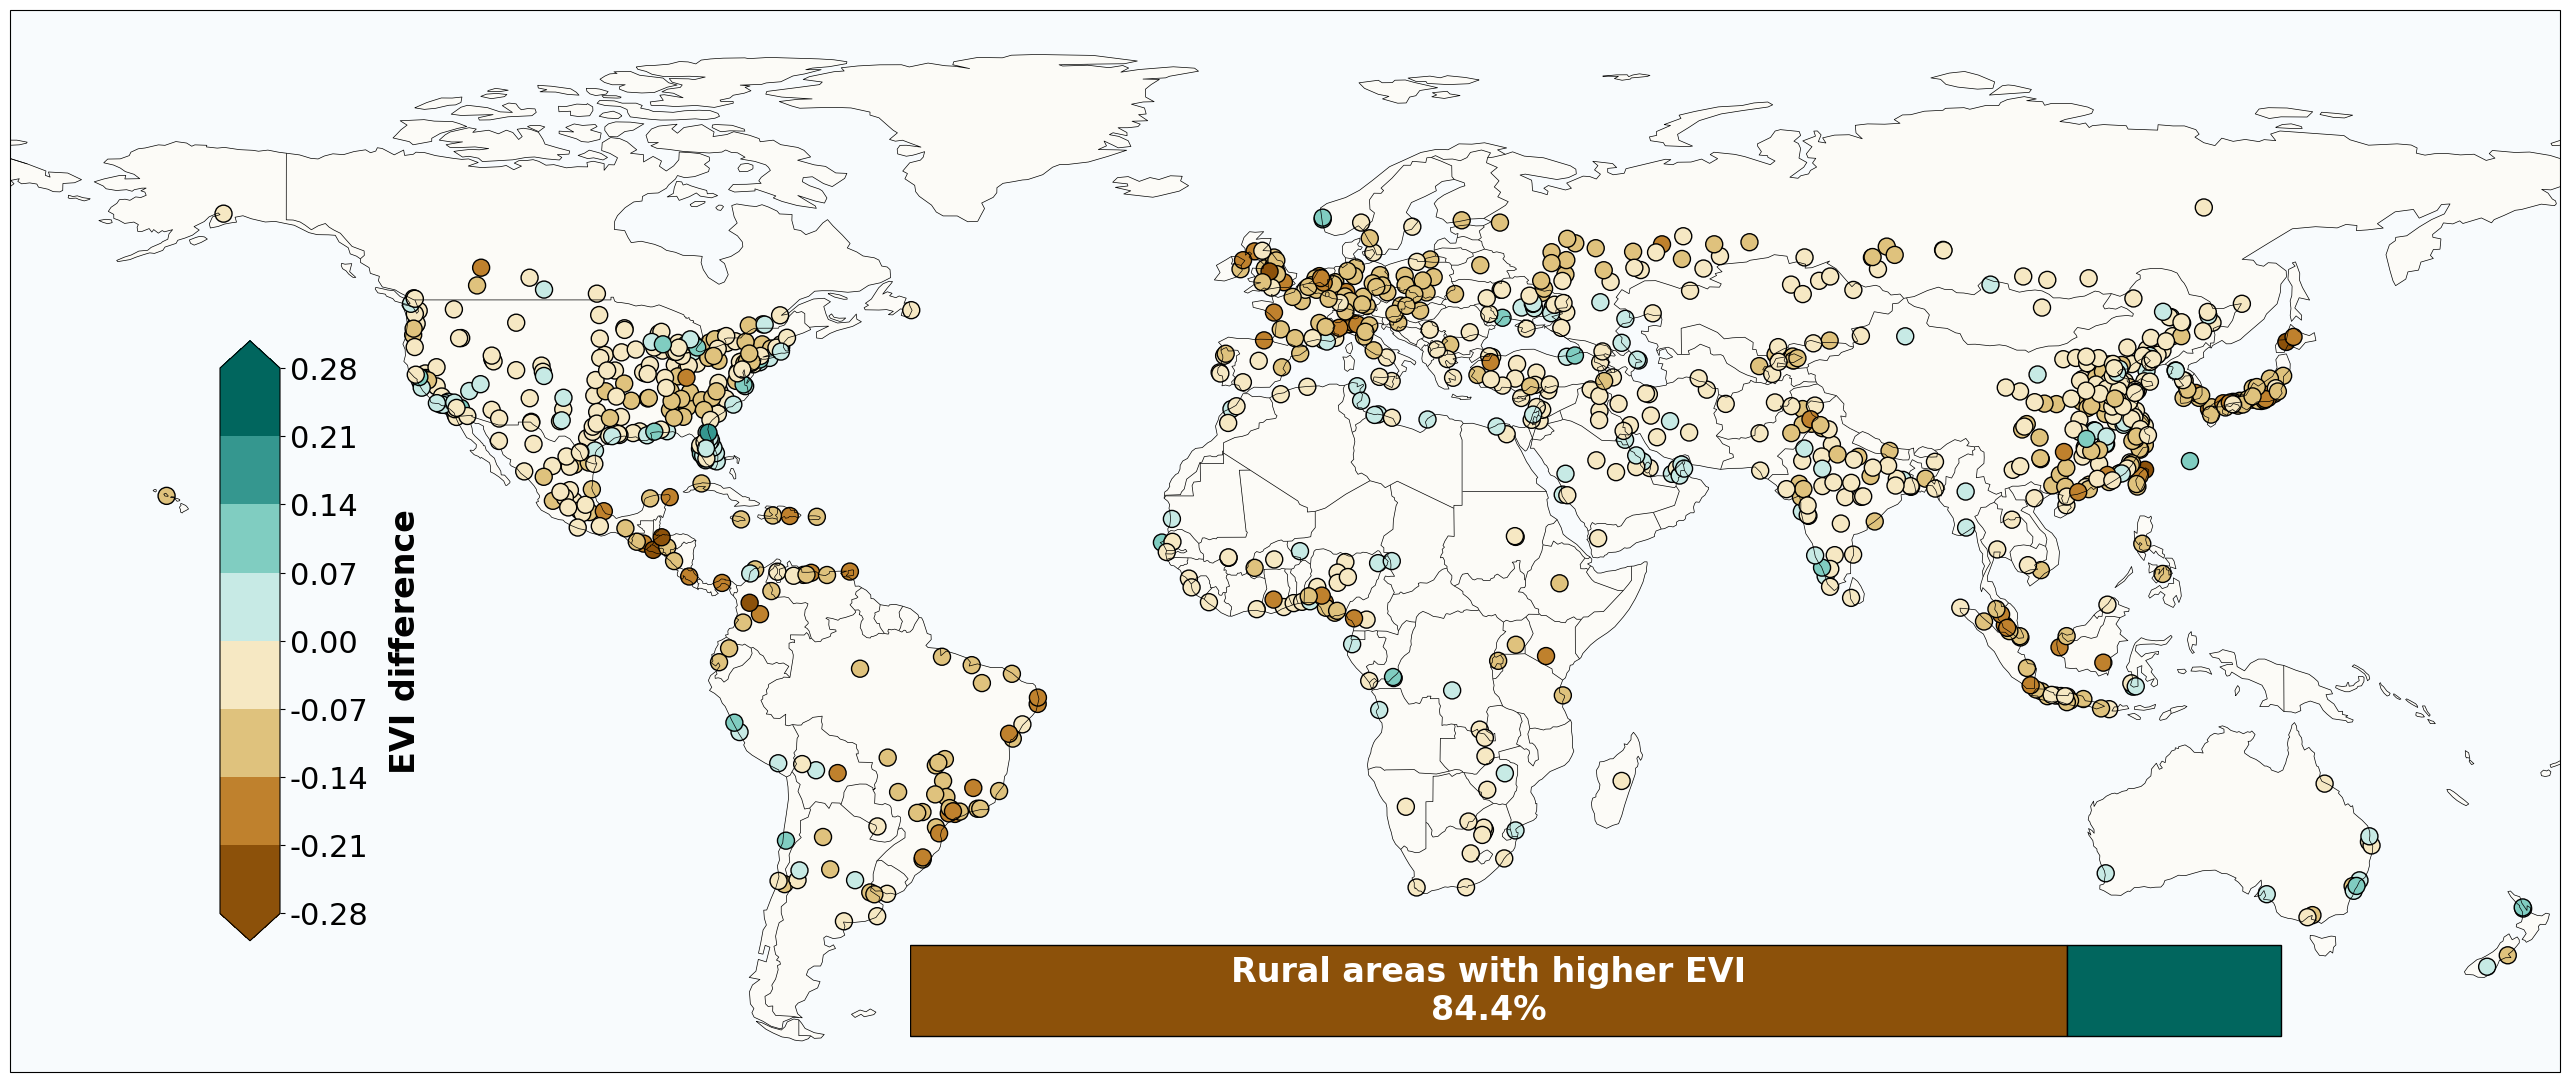

Histogram saved to /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig9_EVI_hist.pdf


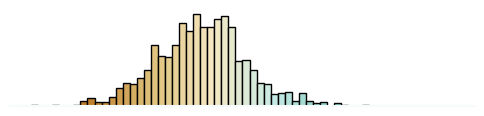

--- EVI difference summary (top 1000 by Urban_Area) ---
Cities plotted: 1000
Urban higher EVI (diff > 0): 156 (15.6%)
Rural higher EVI (diff < 0): 844 (84.4%)
Equal EVI (diff == 0): 0 (0.0%)
Color scale bounds: [-0.28, 0.28] with 0 as class break


In [7]:
#!/usr/bin/env python3

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

# ---- Config ----
ABS_MAX_CAP = 0.5  # cap for EVI difference color scaling (±0.5 typical for EVI Δ)
N_COLORS = 8       # even number => 0 lies on a bin boundary (class break), not a color
HIST_BINS = 60
OUT_DIR = '/content/drive/MyDrive/UrbanVegetation/FiguresV3'
MAP_NAME = 'EDFig9_EVI_map.pdf'
HIST_NAME = 'EDFig9_EVI_hist.pdf'

# Diverging palette (brown → teal), even number of colors (no center color)
PALETTE = [
    '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',  # brown side
    '#c7eae5', '#80cdc1', '#35978f', '#01665e'   # teal side
]

REQUIRED_COLUMNS = ['meanEVI_2020_urban', 'meanEVI_2020_rural', 'lat', 'lon', 'Urban_Area']


def _validate_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure required columns exist & numeric; drop NaNs and out-of-range coords."""
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Required columns missing: {missing}")

    # Coerce to numeric
    for c in REQUIRED_COLUMNS:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Drop NaNs
    df = df.dropna(subset=REQUIRED_COLUMNS)
    if df.empty:
        raise ValueError("No valid rows remain after dropping NaNs in required columns.")

    # Drop invalid lat/lon
    valid_coords = (df['lat'].between(-90, 90)) & (df['lon'].between(-180, 180))
    df = df[valid_coords]
    if df.empty:
        raise ValueError("All rows removed due to invalid lat/lon ranges.")

    return df


def _compute_bounds(series: pd.Series, n_colors: int, cap: float) -> np.ndarray:
    """
    Compute symmetric bounds around 0 with an even number of bins.
    Ensures 0 is a class break, not a color.
    """
    # EVI difference realistically in [-0.5, 0.5]; still derive from data then cap
    s = series.dropna().clip(lower=-1.0, upper=1.0)
    if s.empty:
        # fall back to ±cap if series is empty after clipping
        abs_max = cap
    else:
        abs_max = min(cap, max(abs(s.min()), abs(s.max())))
        # guard against degenerate case
        if abs_max <= 0:
            abs_max = cap

    bounds = np.linspace(-abs_max, abs_max, n_colors + 1)
    # Sanity: with even n_colors, mid bound must be ~0
    mid = bounds.size // 2
    if not np.isclose(bounds[mid], 0.0, atol=1e-8):
        # force exact zero at center boundary
        bounds[mid] = 0.0
    return bounds


def create_frequency_histogram(series, lo, hi, bins, cmap_cont, out_dir, out_name):
    """Minimalist frequency histogram with continuous palette."""
    vals = series[(series >= lo) & (series <= hi)].dropna()
    if vals.empty:
        print("Histogram: no data within specified bounds.")
        return

    edges = np.linspace(lo, hi, bins + 1)
    fig, ax = plt.subplots(figsize=(6, 1.25))
    try:
        counts, edges, patches = ax.hist(vals, bins=edges, edgecolor='black')
    except Exception as e:
        print(f"Error generating histogram: {e}")
        plt.close(fig)
        return

    norm = plt.Normalize(vmin=lo, vmax=hi)
    for patch, left, right in zip(patches, edges[:-1], edges[1:]):
        patch.set_facecolor(cmap_cont(norm((left + right) / 2.0)))

    # Minimalist styling
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('#f6fbfc')
    ax.spines['bottom'].set_linewidth(1.5)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, out_name)
    try:
        plt.savefig(out_path, dpi=400, bbox_inches='tight', transparent=True)
        print(f"Histogram saved to {out_path}")
    except Exception as e:
        print(f"Error saving histogram: {e}")
    finally:
        plt.show()
        plt.close(fig)


def analyze_EVI_difference(file_path: str):
    """
    Loads data, computes EVI_diff = meanEVI_2020_urban − meanEVI_2020_rural,
    selects top 1000 by Urban_Area, plots world scatter + stacked bar, and writes a histogram.
    """
    # 1) Load
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file does not exist: {file_path}")

    # Prefer CSV for this dataset, but allow vector files too.
    try:
        if file_path.lower().endswith(('.csv', '.tsv')):
            df = pd.read_csv(file_path)
        else:
            # Attempt to read with geopandas (shp/gpkg/geojson, etc.)
            gdf = gpd.read_file(file_path)
            df = pd.DataFrame(gdf)
    except Exception as e:
        raise FileNotFoundError(f"Error reading file '{file_path}': {e}")

    # 2) Validate & clean
    df = _validate_and_clean(df)

    # 3) Compute EVI difference and clamp to reasonable limits
    df['EVI_diff'] = (df['meanEVI_2020_urban'] - df['meanEVI_2020_rural']).clip(-1.0, 1.0)

    # 4) Top 1000 by Urban_Area (after cleaning)
    df = df.nlargest(1000, 'Urban_Area').copy()
    if df.empty:
        raise ValueError("No rows available after selecting top 1000 by Urban_Area.")

    # 5) Colormap/bounds with 0 as class break
    bounds = _compute_bounds(df['EVI_diff'], N_COLORS, ABS_MAX_CAP)
    cmap_disc = ListedColormap(PALETTE)
    norm_disc = BoundaryNorm(bounds, ncolors=len(PALETTE), clip=True)

    # 6) Map
    fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.08)
    ax.add_feature(cfeature.LAND, facecolor='#fcfbf7')

    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df['EVI_diff'],
        cmap=cmap_disc, norm=norm_disc,
        s=150, edgecolors='black', linewidths=1,
        transform=ccrs.PlateCarree()
    )

    # Colorbar (ticks exactly at class boundaries)
    cax = fig.add_axes([0.17, 0.30, 0.02, 0.30])
    cbar = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
    cbar.set_label('EVI difference', fontsize=24, labelpad=15, weight='bold')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([f"{b:.2f}" for b in bounds])
    cbar.ax.tick_params(labelsize=22)

    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # 7) Stacked bar (Rural-higher on left; Urban-higher on right)
    pos = int((df['EVI_diff'] > 0).sum())
    neg = int((df['EVI_diff'] < 0).sum())
    zeros = int((df['EVI_diff'] == 0).sum())
    total = len(df)

    # Percentages over all selected cities (including zeros so the bar sums ≤ 100 if zeros exist)
    p_pos = 100.0 * pos / total if total else 0.0
    p_neg = 100.0 * neg / total if total else 0.0
    leftover = max(0.0, 100.0 - (p_pos + p_neg))  # share of exact zeros

    bar_ax = fig.add_axes([0.40, 0.25, 0.48, 0.05])
    bar_ax.set_axis_off()

    # Left: Rural higher (negative diffs)
    bar_ax.barh([''], [p_neg], color=PALETTE[0], edgecolor='black', height=0.4, label='Rural higher')

    # Middle (if any): exact 0 (neutral) as a light grey sliver
    if leftover > 0:
        bar_ax.barh([''], [leftover], left=p_neg, color='#e6e6e6', edgecolor='black', height=0.4, label='Equal')

    # Right: Urban higher (positive diffs)
    left_offset = p_neg + leftover
    bar_ax.barh([''], [p_pos], left=left_offset, color=PALETTE[-1], edgecolor='black', height=0.4, label='Urban higher')

    # Text labels
    if p_neg > 0:
        bar_ax.text(p_neg / 2, 0, f"Rural areas with higher EVI\n{p_neg:.1f}%", ha='center', va='center',
                    fontsize=24, color='white', weight='bold')
    if p_pos > 0:
        bar_ax.text(left_offset + p_pos / 2, 0, f"", ha='center', va='center',
                    fontsize=24, color='white', weight='bold')

    plt.subplots_adjust(left=0.10, right=0.95, top=0.95, bottom=0.05)

    # 8) Save map
    os.makedirs(OUT_DIR, exist_ok=True)
    map_path = os.path.join(OUT_DIR, MAP_NAME)
    try:
        plt.savefig(map_path, dpi=400, bbox_inches='tight', transparent=True)
        print(f"Map saved to {map_path}")
    except Exception as e:
        print(f"Error saving scatter map: {e}")
    finally:
        plt.show()
        plt.close(fig)

    # 9) Histogram with continuous palette over same capped bounds
    cmap_cont = LinearSegmentedColormap.from_list("EVI_cont", PALETTE, N=256)
    create_frequency_histogram(
        series=df['EVI_diff'],
        lo=bounds[0],
        hi=bounds[-1],
        bins=HIST_BINS,
        cmap_cont=cmap_cont,
        out_dir=OUT_DIR,
        out_name=HIST_NAME
    )

    # 10) Print summary
    print("--- EVI difference summary (top 1000 by Urban_Area) ---")
    print(f"Cities plotted: {total}")
    print(f"Urban higher EVI (diff > 0): {pos} ({p_pos:.1f}%)")
    print(f"Rural higher EVI (diff < 0): {neg} ({p_neg:.1f}%)")
    print(f"Equal EVI (diff == 0): {zeros} ({leftover:.1f}%)")
    print(f"Color scale bounds: [{bounds[0]:.2f}, {bounds[-1]:.2f}] with 0 as class break")


if __name__ == "__main__":
    # Example path; update as needed
    input_file = '/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv'
    try:
        analyze_EVI_difference(input_file)
    except Exception as e:
        print(f"Analysis failed: {e}")
        sys.exit(1)


#GNGS

Valid rows after cleaning: 80,341 of 83,102

[Global North] Area-weighted stats for ΔEVI (Weights: Urban_Area + Buffer_area):
  n_raw                : 30621
  n_eff (Kish)         : 464.1
  μ_w (weighted mean)  : -0.0535
  SE_w (weighted)      : 0.0029
  U > R                : 4282 / 30621 (14.0%)

[Global South] Area-weighted stats for ΔEVI (Weights: Urban_Area + Buffer_area):
  n_raw                : 49720
  n_eff (Kish)         : 1247.1
  μ_w (weighted mean)  : -0.0516
  SE_w (weighted)      : 0.0016
  U > R                : 11012 / 49720 (22.1%)

─ Tests on unweighted ΔEVI distributions ─
Mann–Whitney U p-value : 0.0000e+00
Kolmogorov–Smirnov p   : 0.0000e+00
Cohen’s d (effect size): -0.334


/tmp/ipython-input-2276644322.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Figure saved → /content/drive/MyDrive/UrbanVegetation/FiguresV3/EVI_GNGS.pdf


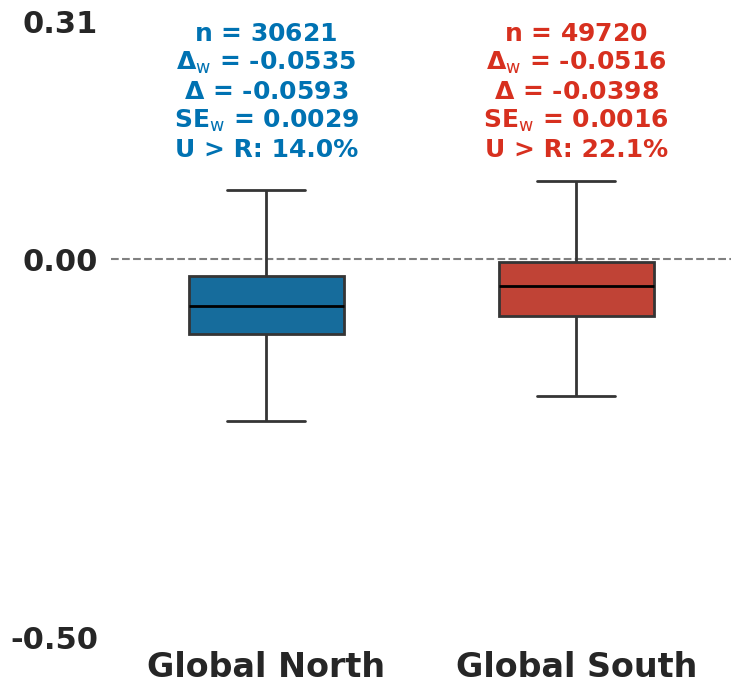

In [8]:
#!/usr/bin/env python3


from __future__ import annotations
import os
import sys
import math
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp


# ----------------------------- CONFIG --------------------------------
INPUT_CSV  = Path('/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv')
OUTPUT_FIG = Path('/content/drive/MyDrive/UrbanVegetation/FiguresV3/EVI_GNGS.pdf')

GROUP_COL  = 'GlobalNS'
PLOT_ORDER = ['Global North', 'Global South']  # fixed left→right order

# Okabe–Ito blue, Vermilion
PALETTE = {'Global North': '#0072B2', 'Global South': '#d7301f'}


# ----------------------------- HELPERS --------------------------------
def _ext_from_path(p: Path) -> str:
    ext = p.suffix.lower().lstrip('.')
    return ext if ext in {'pdf', 'png', 'svg'} else 'pdf'


def _safe_y_limits(values: pd.Series) -> Tuple[float, float]:
    """Ensure 0 is within range; add small padding; avoid zero-span."""
    v = pd.to_numeric(values, errors='coerce').dropna().astype(float)
    if v.empty:
        return (-0.1, 0.1)
    vmin, vmax = float(np.min(v)), float(np.max(v))
    vmin = min(vmin, 0.0)
    vmax = max(vmax, 0.0)
    if np.isclose(vmin, vmax):
        pad = max(abs(vmax), 0.01) * 0.1
        vmin, vmax = vmax - pad, vmax + pad
    span = vmax - vmin
    return (vmin - 0.02 * span, vmax + 0.02 * span)


def _kish_weighted_mean_se(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float, int]:
    """
    Kish-weighted mean and SE:
      μ_w   = Σ w x / Σ w
      Var_w = Σ w (x − μ_w)^2 / Σ w
      n_eff = (Σ w)^2 / Σ w^2
      SE_w  = sqrt(Var_w / max(n_eff, 1))
    Returns (mean_w, se_w, n_eff, n_raw)
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    n_raw = int(x.size)
    if n_raw == 0:
        return (np.nan, np.nan, 0.0, 0)
    W = float(np.sum(w))
    mu_w = float(np.sum(w * x) / W)
    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return (mu_w, se_w, n_eff, n_raw)


# ----------------------------- PLOTTING --------------------------------
def _boxplot_with_annotations(df: pd.DataFrame,
                              feature: str,
                              stats_w: Dict[str, Dict[str, float]],
                              outfile: Path) -> None:
    if df.empty:
        raise ValueError("Nothing to plot – dataframe is empty.")

    plt.rcParams.update({'font.size': 24})
    sns.set(style="white")
    fig = plt.figure(figsize=(8, 8), facecolor="none")
    ax = plt.gca()
    ax.set_facecolor("none")

    # Unweighted boxplot for distributional shape
    sns.boxplot(
        x=GROUP_COL, y=feature, data=df,
        order=PLOT_ORDER, palette=PALETTE, width=0.5, showfliers=False,
        boxprops={'alpha': 1, 'linewidth': 2},
        whiskerprops={'linewidth': 2},
        capprops={'linewidth': 2},
        medianprops={'linewidth': 2, 'color': 'black'}
    )

    # y=0 reference
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, zorder=0)

    # y-lims and ticks
    ymin, ymax = _safe_y_limits(df[feature])
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([ax.get_ylim()[0], 0, ax.get_ylim()[1]])
    ax.set_yticklabels([f"{ax.get_ylim()[0]:.2f}", "0.00", f"{ax.get_ylim()[1]:.2f}"])

    # Minimal axes
    sns.despine(left=True, bottom=True, trim=True, offset=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    plt.yticks(fontsize=22, fontweight='bold')
    plt.xticks(fontsize=24, fontweight='bold')

    # Annotations (μ_w, μ, SE_w, n, U>R %), bold mathtext + subscript w
    y0, y1 = ax.get_ylim()
    for i, label in enumerate(PLOT_ORDER):
        st = stats_w.get(label)
        if not st:
            continue
        y_pos = y1 - 0.0 * (y1 - y0)  # 5% below the top
        ann = (
            rf"$\mathbf{{n}}$ = {st['n_raw']}" + "\n" +
            rf"$\boldsymbol{{\Delta}}_{{\mathrm{{w}}}}$ = {st['mu_w']:.4f}" + "\n" +
            rf"$\boldsymbol{{\Delta}}$ = {st['mu_simple']:.4f}" + "\n" +
            rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {st['se_w']:.4f}" + "\n" +
            f"U > R: {st['pct_pos']:.1f}%"
        )
        ax.text(
            i, y_pos, ann,
            ha='center', va='top', fontsize=18, fontweight='bold',
            color=PALETTE.get(label, 'black')
        )

    # Save
    outfile.parent.mkdir(parents=True, exist_ok=True)
    fmt = _ext_from_path(outfile)
    plt.savefig(outfile, dpi=400, bbox_inches='tight', format=fmt, transparent=True)
    print(f"Figure saved → {outfile}")
    plt.show()


# ----------------------------- CORE ANALYSIS ---------------------------
def analyse_all_cities_evi(csv_path: Path, outfig: Path) -> pd.DataFrame:
    if not csv_path.is_file():
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    # Try to read Buffer_area if available (preferred weights)
    candidate_cols = [
        'meanEVI_2020_urban', 'meanEVI_2020_rural', 'GlobalNS', 'Urban_Area', 'Buffer_area'
    ]
    try:
        df = pd.read_csv(csv_path, usecols=lambda c: c in candidate_cols)
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {e}")

    # Required basics
    req_min = ['meanEVI_2020_urban', 'meanEVI_2020_rural', 'GlobalNS', 'Urban_Area']
    missing_min = [c for c in req_min if c not in df.columns]
    if missing_min:
        raise ValueError(f"Required column(s) missing: {missing_min}")

    # Coerce numerics
    num_cols = [c for c in ['meanEVI_2020_urban', 'meanEVI_2020_rural', 'Urban_Area', 'Buffer_area'] if c in df.columns]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Clean
    before = len(df)
    df = df.dropna(subset=req_min).copy()
    df = df[df['Urban_Area'] > 0].copy()
    after = len(df)
    print(f"Valid rows after cleaning: {after:,} of {before:,}")
    if after == 0:
        raise ValueError("No valid data rows remain after cleaning.")

    # Compute ΔEVI and group labels
    df['EVI_diff'] = df['meanEVI_2020_urban'] - df['meanEVI_2020_rural']
    df[GROUP_COL] = df['GlobalNS'].replace({'North': 'Global North', 'South': 'Global South'})
    df = df[df[GROUP_COL].isin(PLOT_ORDER)].copy()
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], categories=PLOT_ORDER, ordered=True)

    # Weights for per-city difference
    if 'Buffer_area' in df.columns and df['Buffer_area'].notna().any():
        df = df.dropna(subset=['Buffer_area']).copy()
        df = df[df['Buffer_area'] > 0].copy()
        if df.empty:
            raise ValueError("No valid rows after requiring positive Buffer_area.")
        df['w_diff'] = df['Urban_Area'] + df['Buffer_area']
        weight_note = "Weights: Urban_Area + Buffer_area"
    else:
        df['w_diff'] = df['Urban_Area']
        weight_note = "Weights: Urban_Area only (Buffer_area missing)"
        print(f"[WARN] Buffer_area not found; using Urban_Area as weights.")

    # Stats per group
    stats_w: Dict[str, Dict[str, float]] = {}
    for g in PLOT_ORDER:
        gdf = df[df[GROUP_COL] == g]
        x = gdf['EVI_diff'].to_numpy()
        w = gdf['w_diff'].to_numpy()

        mu_w, se_w, n_eff, n_raw = _kish_weighted_mean_se(x, w)
        mu_simple = float(np.nanmean(x)) if x.size else float('nan')
        n_pos = int(np.sum(x > 0))
        pct_pos = 100.0 * n_pos / n_raw if n_raw > 0 else np.nan

        stats_w[g] = {
            'n_raw': n_raw,
            'n_eff': n_eff,
            'mu_w': mu_w,
            'mu_simple': mu_simple,
            'se_w': se_w,
            'pct_pos': pct_pos
        }

        # Console diagnostics
        print(f"\n[{g}] Area-weighted stats for ΔEVI ({weight_note}):")
        print(f"  n_raw                : {n_raw}")
        print(f"  n_eff (Kish)         : {n_eff:.1f}")
        print(f"  μ_w (weighted mean)  : {mu_w:.4f}")
        print(f"  SE_w (weighted)      : {se_w:.4f}")
        print(f"  U > R                : {n_pos} / {n_raw} ({pct_pos:.1f}%)")

    # Hypothesis tests on unweighted distributions (as descriptive checks)
    north = df.loc[df[GROUP_COL] == 'Global North', 'EVI_diff']
    south = df.loc[df[GROUP_COL] == 'Global South', 'EVI_diff']

    try:
        mw_u, mw_p = mannwhitneyu(north, south, alternative='two-sided')
    except ValueError as e:
        mw_u, mw_p = float('nan'), float('nan')
        print(f"[WARN] Mann–Whitney failed: {e}")

    try:
        ks_s, ks_p = ks_2samp(north, south)
    except ValueError as e:
        ks_s, ks_p = float('nan'), float('nan')
        print(f"[WARN] KS test failed: {e}")

    pooled_sd = math.sqrt((north.var(ddof=1) + south.var(ddof=1)) / 2.0) if (north.size > 1 and south.size > 1) else float('nan')
    cohens_d = ((north.mean() - south.mean()) / pooled_sd) if (pooled_sd and not np.isnan(pooled_sd)) else float('nan')

    print("\n─ Tests on unweighted ΔEVI distributions ─")
    print(f"Mann–Whitney U p-value : {mw_p:.4e}" if np.isfinite(mw_p) else "Mann–Whitney U p-value : n/a")
    print(f"Kolmogorov–Smirnov p   : {ks_p:.4e}" if np.isfinite(ks_p) else "Kolmogorov–Smirnov p   : n/a")
    print(f"Cohen’s d (effect size): {cohens_d:.3f}" if np.isfinite(cohens_d) else "Cohen’s d (effect size): n/a")

    # Plot
    _boxplot_with_annotations(df[[GROUP_COL, 'EVI_diff']], 'EVI_diff', stats_w, outfig)
    return df


# ----------------------------- CLI ------------------------------------
def main() -> None:
    try:
        analyse_all_cities_evi(INPUT_CSV, OUTPUT_FIG)
    except (FileNotFoundError, ValueError, RuntimeError) as e:
        print(f"[ERROR] {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"[ERROR] Unexpected: {e}", file=sys.stderr)
        sys.exit(2)


if __name__ == "__main__":
    main()


# Climate Zones

/usr/local/lib/python3.12/dist-packages/ptitprince/PtitPrince.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in self.plot_data.groupby(grouping_vars):
/tmp/ipython-input-291356573.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


Saved RainCloud plot → /content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig_EVI_climate.pdf


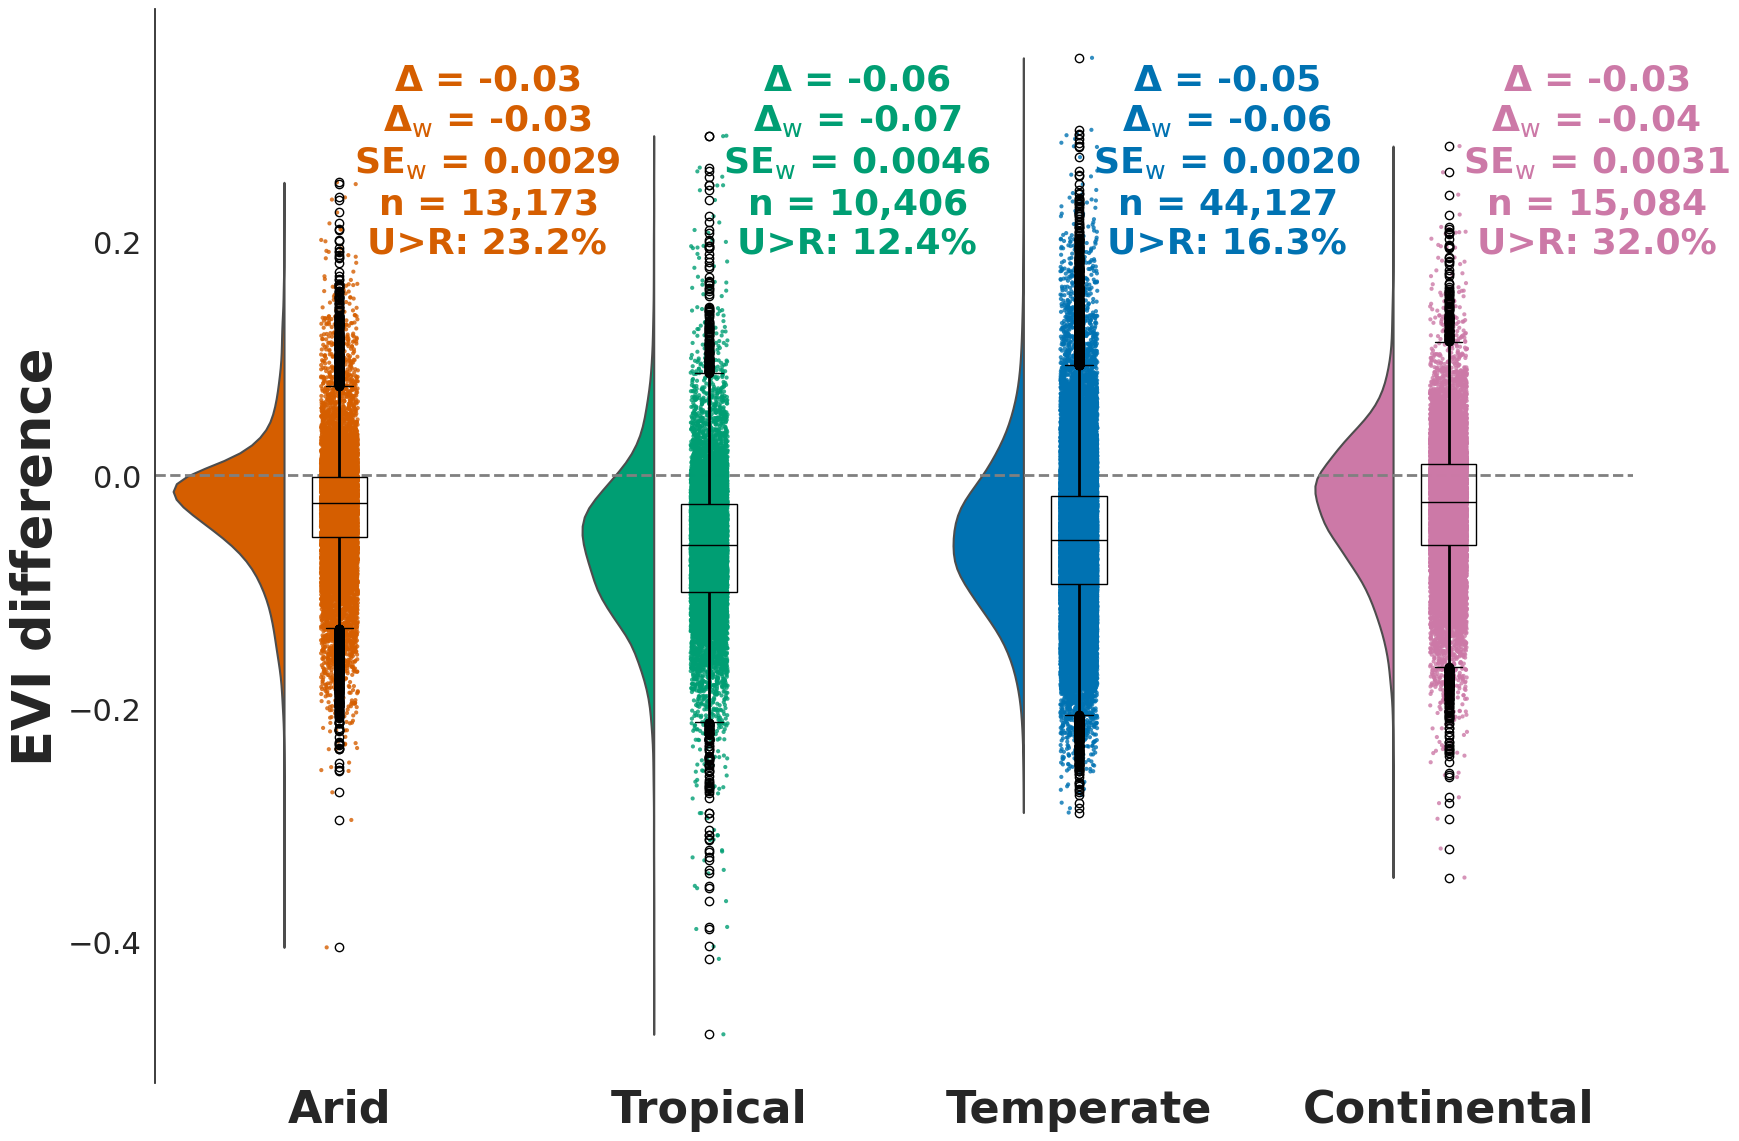

In [9]:
#!/usr/bin/env python3

import sys
import warnings
from pathlib import Path
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

# ────────────────────────────────────────────────────────────────────
# SILENCE KNOWN FUTUREWARNINGS (optional)
# ────────────────────────────────────────────────────────────────────
warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated",
    category=FutureWarning,
    module="seaborn"
)

# ────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────
INPUT_CSV  = Path('/content/combinedFeatures_EVIBiomeKoppen_withLatLon_with_countries_global_ns.csv')
OUTPUT_pdf = Path('/content/drive/MyDrive/UrbanVegetation/FiguresV3/EDFig_EVI_climate.pdf')

# Fixed class ordering and palette (CVD-safe, consistent with other figures)
KOPPEN_MAP   = {'A': 'Tropical', 'B': 'Arid', 'C': 'Temperate', 'D': 'Continental'}
CLASS_ORDER  = ['Arid', 'Tropical', 'Temperate', 'Continental']
PALETTE_LIST = ["#D55E00", "#009E73", "#0072B2", "#CC79A7"]  # Arid, Tropical, Temperate, Continental

# ────────────────────────────────────────────────────────────────────
# HELPERS
# ────────────────────────────────────────────────────────────────────
def _stderr(series: pd.Series) -> float:
    """Sample standard error (ddof=1). NaN if n < 2 or no finite values."""
    s = pd.to_numeric(series, errors='coerce').dropna()
    n = s.size
    if n < 2:
        return float('nan')
    return float(s.std(ddof=1) / np.sqrt(n))

def _weighted_mean_se_with_kish(x: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    """
    Weighted mean and SE with Kish effective n.
    Returns (mu_w, se_w, n_eff). If invalid, returns (nan, nan, 0.0).
    """
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    if not np.any(m):
        return np.nan, np.nan, 0.0

    x = x[m]
    w = w[m]
    W = float(w.sum())
    if W <= 0:
        return np.nan, np.nan, 0.0

    mu_w = float(np.sum(w * x) / W)
    w2 = float(np.sum(w * w))
    n_eff = (W * W) / w2 if w2 > 0 else 0.0

    var_w = float(np.sum(w * (x - mu_w) ** 2) / W)
    se_w = float(np.sqrt(var_w / max(n_eff, 1.0))) if np.isfinite(var_w) else np.nan
    return mu_w, se_w, n_eff

# ────────────────────────────────────────────────────────────────────
# LOAD DATA
# ────────────────────────────────────────────────────────────────────
try:
    data = pd.read_csv(INPUT_CSV)
except Exception as e:
    raise IOError(f"Error reading CSV file '{INPUT_CSV}': {e}")

# ────────────────────────────────────────────────────────────────────
# VALIDATION & PREPROCESSING
# ────────────────────────────────────────────────────────────────────
required_columns = ['meanEVI_2020_urban', 'meanEVI_2020_rural', 'koppen_name']
missing = [c for c in required_columns if c not in data.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# Coerce numeric columns and drop rows with missing inputs
for col in ['meanEVI_2020_urban', 'meanEVI_2020_rural']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(subset=required_columns, inplace=True)

# Compute EVI urban–rural difference
data['EVI_diff'] = data['meanEVI_2020_urban'] - data['meanEVI_2020_rural']

# Map to first-letter Köppen class (drop Polar 'E' and anything unmapped)
first_letter = data['koppen_name'].astype(str).str[0]
data['koppen_class'] = first_letter.map(KOPPEN_MAP)

# Keep only mapped classes and explicit copy
data = data.dropna(subset=['koppen_class', 'EVI_diff']).copy()

# Enforce fixed category order used in other figures
data['koppen_class'] = pd.Categorical(data['koppen_class'],
                                      categories=CLASS_ORDER,
                                      ordered=True)
data = data.dropna(subset=['koppen_class'])

# If any class is entirely absent, prune palette/order accordingly
present_classes = [c for c in CLASS_ORDER if (data['koppen_class'] == c).any()]
palette = [PALETTE_LIST[CLASS_ORDER.index(c)] for c in present_classes]
data = data[data['koppen_class'].isin(present_classes)]

if data.empty:
    raise ValueError("No data left after class mapping/filtering.")

# Determine whether area weights are available
has_weights = all(col in data.columns for col in ['Urban_Area', 'Buffer_area'])
if has_weights:
    # Guard denominators and form weights for the *difference*
    data['Urban_Area']  = pd.to_numeric(data['Urban_Area'],  errors='coerce').replace(0, np.nan)
    data['Buffer_area'] = pd.to_numeric(data['Buffer_area'], errors='coerce').replace(0, np.nan)
    data['w_diff'] = data['Urban_Area'] + data['Buffer_area']
    if not np.isfinite(data['w_diff']).any() or (data['w_diff'].fillna(0) <= 0).all():
        has_weights = False

# ────────────────────────────────────────────────────────────────────
# CLASS-WISE STATS (weighted if possible; else unweighted)
# ────────────────────────────────────────────────────────────────────
stats = {}
for klass in present_classes:
    grp = data.loc[data['koppen_class'] == klass, 'EVI_diff']
    grp = pd.to_numeric(grp, errors='coerce').dropna()
    n_raw = int(grp.size)
    mu_simple = float(grp.mean()) if n_raw > 0 else float('nan')
    se_simple = _stderr(grp)
    upr_pct = float((grp > 0).mean() * 100.0) if n_raw > 0 else float('nan')

    mu_w = se_w = n_eff = np.nan
    if has_weights:
        x = pd.to_numeric(data.loc[data['koppen_class'] == klass, 'EVI_diff'], errors='coerce').to_numpy()
        w = pd.to_numeric(data.loc[data['koppen_class'] == klass, 'w_diff'],    errors='coerce').to_numpy()
        mu_w, se_w, n_eff = _weighted_mean_se_with_kish(x, w)

    stats[klass] = {
        'n_raw': n_raw,
        'mu_simple': mu_simple,
        'se_simple': se_simple,
        'mu_w': mu_w,
        'se_w': se_w,
        'n_eff': n_eff,
        'upr_pct': upr_pct
    }

# ────────────────────────────────────────────────────────────────────
# PLOTTING (LAI RainCloud style)
# ────────────────────────────────────────────────────────────────────
plt.rcParams.update({"font.size": 26})
fig, ax = plt.subplots(figsize=(18, 12), facecolor='none')  # transparent bg

# RainCloud: half-violin (distribution unweighted)
pt.half_violinplot(
    x='koppen_class', y='EVI_diff', data=data,
    palette=palette, bw=.2, cut=0, scale="area",
    width=.6, inner=None, orient='v', order=present_classes, ax=ax
)

# Boxplot overlay (thin, transparent fill)
sns.boxplot(
    x='koppen_class', y='EVI_diff', data=data,
    width=.15, showcaps=True, boxprops={'facecolor': 'none'},
    whiskerprops={'linewidth': 2}, capprops={'zorder': 10},
    whis=1.5, color='black', zorder=10, order=present_classes, ax=ax
)

# Stripplot overlay
sns.stripplot(
    x='koppen_class', y='EVI_diff', data=data,
    palette=palette, jitter=0.05, size=3, alpha=0.8,
    orient='v', order=present_classes, ax=ax
)

# Zero line & minimalist styling
ax.axhline(0, color='gray', linestyle='--', linewidth=2)
ax.grid(False)
for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='x', length=0)

# Labels
ax.set_ylabel('EVI difference ', fontsize=38, fontweight='bold')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), fontsize=32, fontweight='bold')
plt.yticks(fontsize=22)

# Statistical annotations (match reference layout)
ymin, ymax = ax.get_ylim()
y_text = ymax - 0.05 * (ymax - ymin)

for i, klass in enumerate(present_classes):
    s = stats[klass]
    n_raw     = s['n_raw']
    mu_simple = s['mu_simple']
    se_simple = s['se_simple']
    upr       = s['upr_pct']

    if has_weights and np.isfinite(s['mu_w']):
        mu_w  = s['mu_w']
        se_w  = s['se_w']
        ann = (
            rf"$\boldsymbol{{\Delta}}$ = {mu_simple:.2f}" + "\n" +
            rf"$\boldsymbol{{\Delta}}_{{\mathrm{{w}}}}$ = {mu_w:.2f}" + "\n" +
            rf"$\mathbf{{SE}}_{{\mathrm{{w}}}}$ = {se_w:.4f}" + "\n" +
            rf"$\mathbf{{n}}$ = {n_raw:,}" + "\n" +
            f"U>R: {upr:.1f}%"
        )
    else:
        ann = (
            rf"$\boldsymbol{{\Delta}}$ = {mu_simple:.2f}" + "\n" +
            rf"$\mathbf{{SE}}$ = {se_simple:.4f}" + "\n" +
            rf"$\mathbf{{n}}$ = {n_raw:,}" + "\n" +
            f"U>R: {upr:.1f}%"
        )

    ax.text(
        i + 0.40, y_text, ann,
        ha='center', va='top',
        fontsize=26, fontweight='bold',
        color=palette[i]
    )

plt.tight_layout()

# ────────────────────────────────────────────────────────────────────
# SAVE
# ────────────────────────────────────────────────────────────────────
OUTPUT_pdf.parent.mkdir(parents=True, exist_ok=True)
try:
    fig.savefig(OUTPUT_pdf, dpi=400, bbox_inches='tight', transparent=True)
    print(f"Saved RainCloud plot → {OUTPUT_pdf}")
except Exception as e:
    raise IOError(f"Error saving figure to '{OUTPUT_pdf}': {e}")
finally:
    plt.show()
